**Install requirements**

In [0]:
"""!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'"""
# !pip install --upgrade wandb

"!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm'"

**Import libraries**

In [139]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet # , resnet18, resnet34

from PIL import Image
from tqdm import tqdm
import random

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
DATA_DIR = 'DATA' # here the dataset will be downloaded

NUM_CLASSES = 100 

# @toupdate the following vals (look at icarl paper)

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 49       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Retrieving dataset CIFAR1000**

In [3]:
# Clone github repository with dataset handler
# !rm -r Cifar100/ #debug purposes
if not os.path.isdir('./Cifar100'):
  !git clone https://github.com/danielegenta/Progetto-MLDL.git
  !mv 'Progetto-MLDL' 'Cifar100'
  !rm -r Cifar100/Theoretical-Sources
  !rm -rf Cifar100/ProjectMLDL.ipynb

Cloning into 'Progetto-MLDL'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 139 (delta 57), reused 99 (delta 30), pack-reused 0
Receiving objects: 100% (139/139), 3.46 MiB | 2.78 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
from Cifar100.Dataset.cifar100 import CIFAR100
# Download dataset from the official sourse and save it into DATA

# if not os.path.isdir('./{}'.format(DATA_DIR)):
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xf 'cifar-100-python.tar.gz'  
!mv 'cifar-100-python' $DATA_DIR
!rm -rf 'cifar-100-python.tar.gz'

--2020-05-19 13:47:12--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  16.8MB/s    in 11s     

2020-05-19 13:47:24 (14.9 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]



**Define data preprocessing**

In [0]:
# it is ok to use also .5 mean and .5 std (faq1)
# @tocheck
# ref: https://github.com/chengyangfu/pytorch-vgg-cifar10/blob/master/main.py + pytorch resnet documentation
# Define transformations for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

# Define transformations for evaluation
eval_transform = transforms.Compose([transforms.Resize(32),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                                   
])

**Prepare dataset**

In [26]:
from Cifar100.Dataset.cifar100 import CIFAR100
# Import dataset
# full_dataset = CIFAR100(DATA_DIR, split='train', transform=transform_train)
train_dataset = CIFAR100(DATA_DIR, split='train', transform=transform_train)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)


# @todo
# split into train, test, 
print(len(train_dataset))
print(len(test_dataset))

# random.seed(30)
# rand_subset = random.sample(list(full_dataset.df.index), 10000)
# dataset = Subset(full_dataset, rand_subset)

50000
10000


In [0]:
import pandas as pd
import numpy as np

def build_reverse_index(dataset, splits):
    reverse_index = pd.DataFrame(columns=['group', 'labels'])

    for k in splits.keys():
        labels = list(dataset.df.loc[splits[k]['train'],'labels'].value_counts().index)
        group = [k for i in range(len(labels))]
        data = pd.DataFrame(np.array([group, labels]).T, columns=['group', 'labels'])
        reverse_index = reverse_index.append(data, ignore_index=True)

    reverse_index['nodes'] = reverse_index.index
    return reverse_index

def changeIndex(reverse_index, column):
    reverse_index = reverse_index.set_index(column)
    reverse_index[column] = reverse_index.index
    return reverse_index

def getLabels(reverse_index, outputs):
    outs = outputs.cpu().numpy()
    reverse_index = changeIndex(outputs_labels_mapping, 'nodes')
    labels = reverse_index.loc[outs, 'labels']

    labels = torch.tensor(list(labels))
    return labels.to(DEVICE)

def getNodes(reverse_index, labels):
    labels = labels.cpu().numpy()
    reverse_index = changeIndex(outputs_labels_mapping, 'labels')
    nodes = reverse_index.loc[labels, 'nodes']

    nodes = torch.tensor(list(nodes))
    return nodes.to(DEVICE)

def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = (reverse_index['group'].value_counts().index)
    for g in groups:
        labels_of_groups = reverse_index.loc[reverse_index['group'] == g, 'labels']
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

**Build dataset splits and reverse index**

In [0]:
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=30)
outputs_labels_mapping = build_reverse_index(train_dataset, train_splits)
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

**Prepare dataloaders**

In [110]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    # train_dl = DataLoader(train_subs, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    # val_dl = DataLoader(train_subs, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    # test_dl = DataLoader(test_subs, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
    test_subsets.append(test_subs)



# test to check classes in different dataset
dict_train={}
for img_train in train_subsets[0]:
  if img_train[1] not in dict_train:
    dict_train[img_train[1]]=1
  else:
    dict_train[img_train[1]]+=1
dict_val={}
for img_val in val_subsets[0]:
  if img_val[1] not in dict_val:
    dict_val[img_val[1]]=1
  else:
    dict_val[img_val[1]]+=1
dict_test={}
for img_test in test_subsets[0]:
  if img_test[1] not in dict_test:
    dict_test[img_test[1]]=1
  else:
    dict_test[img_test[1]]+=1

print(sorted(dict_test.keys()))
print(sorted(dict_test.keys()))
print(sorted(dict_test.keys()))

[18, 19, 23, 30, 39, 46, 53, 60, 98, 99]
[18, 19, 23, 30, 39, 46, 53, 60, 98, 99]
[18, 19, 23, 30, 39, 46, 53, 60, 98, 99]


In [0]:
import time

def fake_train(net, train_dataloader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime
    
    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for images, labels in train_dataloader:
            print(labels)
            # Bring data over the device of choice
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad() # Zero-ing the gradients

            outputs = net(images)

            loss = criterion(outputs, labels)
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            print(preds)
            preds = getLabels(outputs_labels_mapping, preds)
            print(preds)

            break
        break
    print('end of fake train')
    


def train(net, train_dataloader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):     
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime
    
    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for images, labels in train_dataloader:
            # Bring data over the device of choice
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad() # Zero-ing the gradients

            outputs = net(images)

            loss = criterion(outputs, labels)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            # preds = getLabels(outputs_labels_mapping, preds)
            # print(preds)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        # wandb.log({'Epochs': epoch, 'Train Accuracy': epoch_acc, 'Train Loss': epoch_loss})
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion=None):
    net.eval()

    running_corrects = 0
    running_loss = 0.0
    for images, labels in val_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass to the network
        outputs = net(images)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        # preds = getLabels(outputs_labels_mapping, preds)
        running_corrects += torch.sum(preds == labels.data).data.item()
        
    # Calculate Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss

def test(net, test_dataloader):
    acc, _ = validate(net, test_dataloader)
    return acc

# Joins 2+ subsets into a new Subset
def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)

def jointTraining(getNet, addOutputs, train_subsets, val_subsets, test_subsets):
    # wandb.init(project="progetto-mldl", name='joint-training', anonymous='never')

    net, criterion, optimizer, scheduler = getNet()
    # wandb.watch(net)

    train_set = None
    test_set = None
    first_pass = True
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):

        # Builds growing train and test set. The new sets include data from previous class groups and current class group
        if train_set is None:
            train_set = train_subset
        else:
            train_set = joinSubsets(train_dataset, [train_set, train_subset])
        if test_set is None:
            test_set = test_subset
        else:
            test_set = joinSubsets(test_dataset, [test_set, test_subset])

        if first_pass:
            first_pass = False
        else:
            addOutputs(net, 10)

        # Trains model on previous and current class groups
        _, _, optimizer, scheduler = getNet()
        train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
        train(net, train_loader, criterion, optimizer, scheduler)

        # Validate model on current class group
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
        acc, loss = validate(net, val_loader, criterion)
        print(acc, loss)

        # Test the model on previous and current class groups
        test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        print(acc)


In [0]:
from Cifar100.resnet import resnet34

def getResNet34(output_size):
    net = resnet34(num_classes=output_size)
    # net.fc = nn.Linear(net.fc.in_features, output_size)

    criterion = nn.CrossEntropyLoss()
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    return net, criterion, optimizer, scheduler

def addOutputsToResNet(net, new_outputs):
    in_features = net.fc.in_features
    out_features = net.fc.out_features
    weight = net.fc.weight.data

    net.fc = nn.Linear(in_features, out_features + new_outputs)
    net.fc.weight.data[:out_features] = weight
def getNet():
    return getResNet34(10)

In [0]:

# jointTraining(getNet, addOutputsToResNet, train_subsets, val_subsets, test_subsets)
# wandb.init(project="progetto-mldl", name='joint-training', anonymous='never')
net, criterion, optimizer, scheduler = getResNet34(100)
# wandb.watch(net)train_dataloader = DataLoader(train_subsets[0], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
train(net, train_dataloader, criterion, optimizer, scheduler)
# outputs_labels_mapping.head(11)

**Catastrophic Forgetting**

In [0]:
### Catastrophic Forgetting
def sequentialLearning(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet34(100)
    groups_accuracies=[]
    i=0
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      # Train on current group
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss = validate(net, val_loader, criterion)
      print("EVALUATION: ",acc, loss)

      # Testo on current group
      test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc = test(net, test_loader)
      groups_accuracies.append(acc)
      print("TEST: ",acc)
      if i==2:
        break
      i+=1
    return net, groups_accuracies

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        if id_group==2:
          break
        id_group+=1
    return dif_accuracies

In [129]:
net, old_accuracies=sequentialLearning(train_subsets, val_subsets, test_subsets)

Starting epoch 1/10, LR = [0.01]


/content/Cifar100/resnet.py:105: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data, mode='fan_out')
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 6.041431427001953
Train step - Step 10, Loss 3.998364210128784
Train step - Step 20, Loss 2.962327003479004
Train step - Step 30, Loss 1.9368914365768433
Train epoch - Accuracy: 0.24868686868686868 Loss: 3.4786440383545076 Corrects: 1231
Starting epoch 2/10, LR = [0.01]
Train step - Step 40, Loss 1.7082616090774536
Train step - Step 50, Loss 1.9721704721450806
Train step - Step 60, Loss 1.6261855363845825
Train step - Step 70, Loss 1.4314048290252686
Train epoch - Accuracy: 0.42747474747474745 Loss: 1.6811614678604434 Corrects: 2116
Starting epoch 3/10, LR = [0.01]
Train step - Step 80, Loss 1.5485889911651611
Train step - Step 90, Loss 1.4031779766082764
Train step - Step 100, Loss 1.3329074382781982
Train step - Step 110, Loss 1.4706218242645264
Train epoch - Accuracy: 0.5036363636363637 Loss: 1.3856758397998232 Corrects: 2493
Starting epoch 4/10, LR = [0.01]
Train step - Step 120, Loss 1.2366238832473755
Train step - Step 130, Loss 1.2114310264587402
Train 

In [132]:
dif_accuracies=printAccuracyDifference(net,old_accuracies)
dif_accuracies

[(1, 0.673, 0.0), (2, 0.677, 0.0), (3, 0.544, 0.544)]

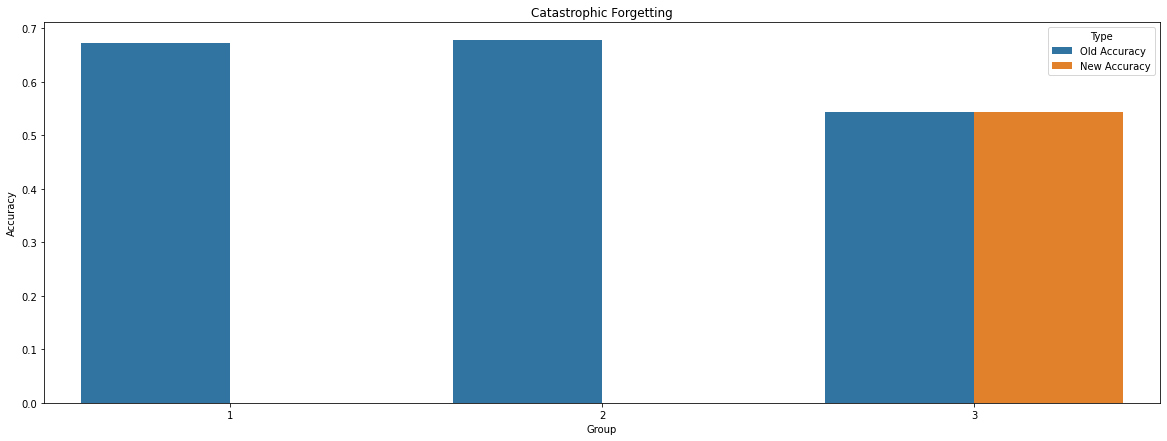

In [141]:
data_plot=[]
for row in dif_accuracies:
    data_plot.append((row[0],"Old Accuracy",row[1]))
    data_plot.append((row[0],"New Accuracy",row[2]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot, columns = ['Group','Type','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",hue="Type",data=accuracyDF)
plt.title("Catastrophic Forgetting")
plt.show()